In [466]:
import numpy as np
from scipy import integrate,interpolate
import pylab as pl
import pandas as pd
import csv
import pickle
from random import choice
from sklearn.model_selection import train_test_split
interpolation_kind_list=['linear','nearest','zero','slinear','quadratic','cubic']
interpolation_kind = interpolation_kind_list[4]
sample_frame = 32
shift_step = 50  # larger means smaller step when shifting 


### IMUData-Collecting
 

In [467]:
data = []
data_time = []
for action in range(1,7):
  for subject in range(1,13):
    for repeat in range(1,6):
      if subject>=10:
        camera_time_stamp = "time_stamps_img_s"+str(subject)+"_a0"+str(action)+"_r0"+str(repeat)
      else:
        camera_time_stamp = "time_stamps_img_s0"+str(subject)+"_a0"+str(action)+"_r0"+str(repeat)
      data_spec_video = []
      for imu in range(1,7):
        if subject>=10:
          file_name_acc = "acc_h0"+str(imu)+"_s"+str(subject)+"_a0"+str(action)+"_r0"+str(repeat)
        else:
          file_name_acc = "acc_h0"+str(imu)+"_s0"+str(subject)+"_a0"+str(action)+"_r0"+str(repeat)
        file = open("C:/Users/zheng/myjupyternotebookscripts/myjupyterscript/Kurs_CACM/Accelerometer/Shimmer0"+str(imu)+"/"+file_name_acc+".txt")
        lines = file.readlines()
        data_spec_imu = []
        for line in lines:
          # line = line.strip("\n")
          # line = line.split()
          line = [float(x) for x in line.split()]
          data_spec_imu.append(line)
        data_spec_video.append(data_spec_imu)
      data.append(data_spec_video)

      camera_time_file = open("C:/Users/zheng/myjupyternotebookscripts/myjupyterscript/Kurs_CACM/Time_stamps/"+camera_time_stamp+".txt")
      camera_time_lines = camera_time_file.readlines()
      data_time_spec_video = []
      for line in camera_time_lines:
        # line = line.strip("\n")
        # line = line.split()
        line = [float(x) for x in line.split()]
        data_time_spec_video.append(line)
      data_time.append(data_time_spec_video)
      

In [468]:
data_array = np.array(data)
data_time_array = np.array(data_time)

C:\Users\zheng\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
C:\Users\zheng\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [469]:
def sample2targetframes(i,data_time,data,sample_frame,shift_step,action,y_data,translation_new):
  
  time = data_time[i]
  time_array = np.array(time)

  ## imu values at own timestamp
  imu_1_array,imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z = imu_translation(data,i,0)
  imu_2_array,imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z = imu_translation(data,i,1)
  imu_3_array,imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z = imu_translation(data,i,2)
  imu_4_array,imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z = imu_translation(data,i,3)
  imu_5_array,imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z = imu_translation(data,i,4)
  imu_6_array,imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z = imu_translation(data,i,5)

  ## let the new time(camera timestamp) lie inside the old time(imu timestamp)
  begin = 0
  max_imu_begin_time = max(imu_1_array[1,3],imu_2_array[1,3],imu_3_array[1,3],imu_4_array[1,3],imu_5_array[1,3],imu_6_array[1,3])
  while max_imu_begin_time > time_array[begin,1]:
    begin = begin+1
  end = 1
  min_imu_end_time = min(imu_1_array[-1,3],imu_2_array[-1,3],imu_3_array[-1,3],imu_4_array[-1,3],imu_5_array[-1,3],imu_6_array[-1,3])
  while min_imu_end_time < time_array[-end,1]:
    end = end+1
  time_new=time_array[begin:-end,1]

  ## f是一个函数，用这个函数就可以找插值点的函数值了：
  f1_x,f1_y,f1_z = interp_function(imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z,interpolation_kind)
  f2_x,f2_y,f2_z = interp_function(imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z,interpolation_kind)
  f3_x,f3_y,f3_z = interp_function(imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z,interpolation_kind)
  f4_x,f4_y,f4_z = interp_function(imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z,interpolation_kind)
  f5_x,f5_y,f5_z = interp_function(imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z,interpolation_kind)
  f6_x,f6_y,f6_z = interp_function(imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z,interpolation_kind)

  down_scale = time_array.shape[0]//sample_frame  #3
  shift_size = sample_frame*down_scale  #96=32*3
  step = shift_size//shift_step  #2=96//40
  sample_num_in_video = (time_new.shape[0]-shift_size)//step+1
  for sample in range(sample_num_in_video):
    time_new_sample = time_new[sample*step:sample*step+shift_size]
    time_new_sample_choice = [choice(time_new_sample[i*down_scale:i*down_scale+down_scale]) for i in range(sample_frame)]
    

    ## imu values at camera timestamp
    new1_x,new1_y,new1_z = returnnew_imu(f1_x,f1_y,f1_z,time_new_sample_choice)
    new2_x,new2_y,new2_z = returnnew_imu(f2_x,f2_y,f2_z,time_new_sample_choice)
    new3_x,new3_y,new3_z = returnnew_imu(f3_x,f3_y,f3_z,time_new_sample_choice)
    new4_x,new4_y,new4_z = returnnew_imu(f4_x,f4_y,f4_z,time_new_sample_choice)
    new5_x,new5_y,new5_z = returnnew_imu(f5_x,f5_y,f5_z,time_new_sample_choice)
    new6_x,new6_y,new6_z = returnnew_imu(f6_x,f6_y,f6_z,time_new_sample_choice)
    
    temp = [new1_x,new1_y,new1_z,new2_x,new2_y,new2_z,new3_x,new3_y,new3_z,new4_x,new4_y,new4_z,new5_x,new5_y,new5_z,new6_x,new6_y,new6_z]
    temp_array = np.array(temp)
    temp_after = temp_array.transpose(1,0)
    translation_new.append(temp_after.tolist())
    
    y_data.append(action)
  return translation_new,y_data 

In [470]:
def sample2targetframes_boxing(i,data_time,data,sample_frame,shift_step,action,y_data,translation_new):
  
  time = data_time[i]
  time_array = np.array(time)

  ## imu values at own timestamp
  imu_1_array,imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z = imu_translation(data,i,0)
  imu_2_array,imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z = imu_translation(data,i,1)
  imu_3_array,imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z = imu_translation(data,i,2)
  imu_4_array,imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z = imu_translation(data,i,3)
  imu_5_array,imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z = imu_translation(data,i,4)
  imu_6_array,imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z = imu_translation(data,i,5)

  ## let the new time(camera timestamp) lie inside the old time(imu timestamp)
  begin = 0
  max_imu_begin_time = max(imu_1_array[1,3],imu_2_array[1,3],imu_3_array[1,3],imu_4_array[1,3],imu_5_array[1,3],imu_6_array[1,3])
  while max_imu_begin_time > time_array[begin,1]:
    begin = begin+1
  end = 1
  min_imu_end_time = min(imu_1_array[-1,3],imu_2_array[-1,3],imu_3_array[-1,3],imu_4_array[-1,3],imu_5_array[-1,3],imu_6_array[-1,3])
  while min_imu_end_time < time_array[-end,1]:
    end = end+1
  time_new=time_array[begin:-end,1]

  ## f是一个函数，用这个函数就可以找插值点的函数值了：
  f1_x,f1_y,f1_z = interp_function(imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z,interpolation_kind)
  f2_x,f2_y,f2_z = interp_function(imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z,interpolation_kind)
  f3_x,f3_y,f3_z = interp_function(imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z,interpolation_kind)
  f4_x,f4_y,f4_z = interp_function(imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z,interpolation_kind)
  f5_x,f5_y,f5_z = interp_function(imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z,interpolation_kind)
  f6_x,f6_y,f6_z = interp_function(imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z,interpolation_kind)

#   down_scale = time_array.shape[0]//sample_frame  #3
  down_scale = 8
  shift_size = sample_frame*down_scale  #96=32*3
#   step = shift_size//shift_step  #2=96//40
  step = 6
  sample_num_in_video = (time_new.shape[0]-shift_size)//step+1
  for sample in range(sample_num_in_video):
    time_new_sample = time_new[sample*step:sample*step+shift_size]
    time_new_sample_choice = [choice(time_new_sample[i*down_scale:i*down_scale+down_scale]) for i in range(sample_frame)]
    
    
    ## imu values at camera timestamp
    new1_x,new1_y,new1_z = returnnew_imu(f1_x,f1_y,f1_z,time_new_sample_choice)
    new2_x,new2_y,new2_z = returnnew_imu(f2_x,f2_y,f2_z,time_new_sample_choice)
    new3_x,new3_y,new3_z = returnnew_imu(f3_x,f3_y,f3_z,time_new_sample_choice)
    new4_x,new4_y,new4_z = returnnew_imu(f4_x,f4_y,f4_z,time_new_sample_choice)
    new5_x,new5_y,new5_z = returnnew_imu(f5_x,f5_y,f5_z,time_new_sample_choice)
    new6_x,new6_y,new6_z = returnnew_imu(f6_x,f6_y,f6_z,time_new_sample_choice)
    
    temp = [new1_x,new1_y,new1_z,new2_x,new2_y,new2_z,new3_x,new3_y,new3_z,new4_x,new4_y,new4_z,new5_x,new5_y,new5_z,new6_x,new6_y,new6_z]
    temp_array = np.array(temp)
    temp_after = temp_array.transpose(1,0)
    translation_new.append(temp_after.tolist())
    
    y_data.append(action)
  return translation_new,y_data 

In [471]:
def sample2targetframes_jumpingjack(i,data_time,data,sample_frame,shift_step,action,y_data,translation_new):
  
  time = data_time[i]
  time_array = np.array(time)

  ## imu values at own timestamp
  imu_1_array,imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z = imu_translation(data,i,0)
  imu_2_array,imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z = imu_translation(data,i,1)
  imu_3_array,imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z = imu_translation(data,i,2)
  imu_4_array,imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z = imu_translation(data,i,3)
  imu_5_array,imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z = imu_translation(data,i,4)
  imu_6_array,imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z = imu_translation(data,i,5)

  ## let the new time(camera timestamp) lie inside the old time(imu timestamp)
  begin = 0
  max_imu_begin_time = max(imu_1_array[1,3],imu_2_array[1,3],imu_3_array[1,3],imu_4_array[1,3],imu_5_array[1,3],imu_6_array[1,3])
  while max_imu_begin_time > time_array[begin,1]:
    begin = begin+1
  end = 1
  min_imu_end_time = min(imu_1_array[-1,3],imu_2_array[-1,3],imu_3_array[-1,3],imu_4_array[-1,3],imu_5_array[-1,3],imu_6_array[-1,3])
  while min_imu_end_time < time_array[-end,1]:
    end = end+1
  time_new=time_array[begin:-end,1]

  ## f是一个函数，用这个函数就可以找插值点的函数值了：
  f1_x,f1_y,f1_z = interp_function(imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z,interpolation_kind)
  f2_x,f2_y,f2_z = interp_function(imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z,interpolation_kind)
  f3_x,f3_y,f3_z = interp_function(imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z,interpolation_kind)
  f4_x,f4_y,f4_z = interp_function(imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z,interpolation_kind)
  f5_x,f5_y,f5_z = interp_function(imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z,interpolation_kind)
  f6_x,f6_y,f6_z = interp_function(imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z,interpolation_kind)

#   down_scale = time_array.shape[0]//sample_frame  #3
  down_scale = 2
  shift_size = sample_frame*down_scale  #96=32*3
#   step = shift_size//shift_step  #2=96//40
  step = 6
  sample_num_in_video = (time_new.shape[0]-shift_size)//step+1
  for sample in range(sample_num_in_video):
    time_new_sample = time_new[sample*step:sample*step+shift_size]
    time_new_sample_choice = [choice(time_new_sample[i*down_scale:i*down_scale+down_scale]) for i in range(sample_frame)]
    
    
    ## imu values at camera timestamp
    new1_x,new1_y,new1_z = returnnew_imu(f1_x,f1_y,f1_z,time_new_sample_choice)
    new2_x,new2_y,new2_z = returnnew_imu(f2_x,f2_y,f2_z,time_new_sample_choice)
    new3_x,new3_y,new3_z = returnnew_imu(f3_x,f3_y,f3_z,time_new_sample_choice)
    new4_x,new4_y,new4_z = returnnew_imu(f4_x,f4_y,f4_z,time_new_sample_choice)
    new5_x,new5_y,new5_z = returnnew_imu(f5_x,f5_y,f5_z,time_new_sample_choice)
    new6_x,new6_y,new6_z = returnnew_imu(f6_x,f6_y,f6_z,time_new_sample_choice)
    
    temp = [new1_x,new1_y,new1_z,new2_x,new2_y,new2_z,new3_x,new3_y,new3_z,new4_x,new4_y,new4_z,new5_x,new5_y,new5_z,new6_x,new6_y,new6_z]
    temp_array = np.array(temp)
    temp_after = temp_array.transpose(1,0)
    translation_new.append(temp_after.tolist())
    
    y_data.append(action)
  return translation_new,y_data 

In [472]:
def sample2targetframes_waving2(i,data_time,data,sample_frame,shift_step,action,y_data,translation_new):
  
  time = data_time[i]
  time_array = np.array(time)

  ## imu values at own timestamp
  imu_1_array,imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z = imu_translation(data,i,0)
  imu_2_array,imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z = imu_translation(data,i,1)
  imu_3_array,imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z = imu_translation(data,i,2)
  imu_4_array,imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z = imu_translation(data,i,3)
  imu_5_array,imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z = imu_translation(data,i,4)
  imu_6_array,imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z = imu_translation(data,i,5)

  ## let the new time(camera timestamp) lie inside the old time(imu timestamp)
  begin = 0
  max_imu_begin_time = max(imu_1_array[1,3],imu_2_array[1,3],imu_3_array[1,3],imu_4_array[1,3],imu_5_array[1,3],imu_6_array[1,3])
  while max_imu_begin_time > time_array[begin,1]:
    begin = begin+1
  end = 1
  min_imu_end_time = min(imu_1_array[-1,3],imu_2_array[-1,3],imu_3_array[-1,3],imu_4_array[-1,3],imu_5_array[-1,3],imu_6_array[-1,3])
  while min_imu_end_time < time_array[-end,1]:
    end = end+1
  time_new=time_array[begin:-end,1]

  ## f是一个函数，用这个函数就可以找插值点的函数值了：
  f1_x,f1_y,f1_z = interp_function(imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z,interpolation_kind)
  f2_x,f2_y,f2_z = interp_function(imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z,interpolation_kind)
  f3_x,f3_y,f3_z = interp_function(imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z,interpolation_kind)
  f4_x,f4_y,f4_z = interp_function(imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z,interpolation_kind)
  f5_x,f5_y,f5_z = interp_function(imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z,interpolation_kind)
  f6_x,f6_y,f6_z = interp_function(imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z,interpolation_kind)

#   down_scale = time_array.shape[0]//sample_frame  #3
  down_scale = 3
  shift_size = sample_frame*down_scale  #96=32*3
#   step = shift_size//shift_step  #2=96//40
  step = 7
  sample_num_in_video = (time_new.shape[0]-shift_size)//step+1
  for sample in range(sample_num_in_video):
    time_new_sample = time_new[sample*step:sample*step+shift_size]
    time_new_sample_choice = [choice(time_new_sample[i*down_scale:i*down_scale+down_scale]) for i in range(sample_frame)]
    
    
    ## imu values at camera timestamp
    new1_x,new1_y,new1_z = returnnew_imu(f1_x,f1_y,f1_z,time_new_sample_choice)
    new2_x,new2_y,new2_z = returnnew_imu(f2_x,f2_y,f2_z,time_new_sample_choice)
    new3_x,new3_y,new3_z = returnnew_imu(f3_x,f3_y,f3_z,time_new_sample_choice)
    new4_x,new4_y,new4_z = returnnew_imu(f4_x,f4_y,f4_z,time_new_sample_choice)
    new5_x,new5_y,new5_z = returnnew_imu(f5_x,f5_y,f5_z,time_new_sample_choice)
    new6_x,new6_y,new6_z = returnnew_imu(f6_x,f6_y,f6_z,time_new_sample_choice)
    
    temp = [new1_x,new1_y,new1_z,new2_x,new2_y,new2_z,new3_x,new3_y,new3_z,new4_x,new4_y,new4_z,new5_x,new5_y,new5_z,new6_x,new6_y,new6_z]
    temp_array = np.array(temp)
    temp_after = temp_array.transpose(1,0)
    translation_new.append(temp_after.tolist())
    
    y_data.append(action)
  return translation_new,y_data 

In [473]:
def sample2targetframes_waving1(i,data_time,data,sample_frame,shift_step,action,y_data,translation_new):
  
  time = data_time[i]
  time_array = np.array(time)

  ## imu values at own timestamp
  imu_1_array,imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z = imu_translation(data,i,0)
  imu_2_array,imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z = imu_translation(data,i,1)
  imu_3_array,imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z = imu_translation(data,i,2)
  imu_4_array,imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z = imu_translation(data,i,3)
  imu_5_array,imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z = imu_translation(data,i,4)
  imu_6_array,imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z = imu_translation(data,i,5)

  ## let the new time(camera timestamp) lie inside the old time(imu timestamp)
  begin = 0
  max_imu_begin_time = max(imu_1_array[1,3],imu_2_array[1,3],imu_3_array[1,3],imu_4_array[1,3],imu_5_array[1,3],imu_6_array[1,3])
  while max_imu_begin_time > time_array[begin,1]:
    begin = begin+1
  end = 1
  min_imu_end_time = min(imu_1_array[-1,3],imu_2_array[-1,3],imu_3_array[-1,3],imu_4_array[-1,3],imu_5_array[-1,3],imu_6_array[-1,3])
  while min_imu_end_time < time_array[-end,1]:
    end = end+1
  time_new=time_array[begin:-end,1]

  ## f是一个函数，用这个函数就可以找插值点的函数值了：
  f1_x,f1_y,f1_z = interp_function(imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z,interpolation_kind)
  f2_x,f2_y,f2_z = interp_function(imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z,interpolation_kind)
  f3_x,f3_y,f3_z = interp_function(imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z,interpolation_kind)
  f4_x,f4_y,f4_z = interp_function(imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z,interpolation_kind)
  f5_x,f5_y,f5_z = interp_function(imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z,interpolation_kind)
  f6_x,f6_y,f6_z = interp_function(imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z,interpolation_kind)

#   down_scale = time_array.shape[0]//sample_frame  #3
  down_scale = 3
  shift_size = sample_frame*down_scale  #96=32*3
#   step = shift_size//shift_step  #2=96//40
  step = 7
  sample_num_in_video = (time_new.shape[0]-shift_size)//step+1
  for sample in range(sample_num_in_video):
    time_new_sample = time_new[sample*step:sample*step+shift_size]
    time_new_sample_choice = [choice(time_new_sample[i*down_scale:i*down_scale+down_scale]) for i in range(sample_frame)]
    
    
    ## imu values at camera timestamp
    new1_x,new1_y,new1_z = returnnew_imu(f1_x,f1_y,f1_z,time_new_sample_choice)
    new2_x,new2_y,new2_z = returnnew_imu(f2_x,f2_y,f2_z,time_new_sample_choice)
    new3_x,new3_y,new3_z = returnnew_imu(f3_x,f3_y,f3_z,time_new_sample_choice)
    new4_x,new4_y,new4_z = returnnew_imu(f4_x,f4_y,f4_z,time_new_sample_choice)
    new5_x,new5_y,new5_z = returnnew_imu(f5_x,f5_y,f5_z,time_new_sample_choice)
    new6_x,new6_y,new6_z = returnnew_imu(f6_x,f6_y,f6_z,time_new_sample_choice)
    
    temp = [new1_x,new1_y,new1_z,new2_x,new2_y,new2_z,new3_x,new3_y,new3_z,new4_x,new4_y,new4_z,new5_x,new5_y,new5_z,new6_x,new6_y,new6_z]
    temp_array = np.array(temp)
    temp_after = temp_array.transpose(1,0)
    translation_new.append(temp_after.tolist())
    
    y_data.append(action)
  return translation_new,y_data 

In [474]:
def sample2targetframes_clapping(i,data_time,data,sample_frame,shift_step,action,y_data,translation_new):
  
  time = data_time[i]
  time_array = np.array(time)

  ## imu values at own timestamp
  imu_1_array,imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z = imu_translation(data,i,0)
  imu_2_array,imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z = imu_translation(data,i,1)
  imu_3_array,imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z = imu_translation(data,i,2)
  imu_4_array,imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z = imu_translation(data,i,3)
  imu_5_array,imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z = imu_translation(data,i,4)
  imu_6_array,imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z = imu_translation(data,i,5)

  ## let the new time(camera timestamp) lie inside the old time(imu timestamp)
  begin = 0
  max_imu_begin_time = max(imu_1_array[1,3],imu_2_array[1,3],imu_3_array[1,3],imu_4_array[1,3],imu_5_array[1,3],imu_6_array[1,3])
  while max_imu_begin_time > time_array[begin,1]:
    begin = begin+1
  end = 1
  min_imu_end_time = min(imu_1_array[-1,3],imu_2_array[-1,3],imu_3_array[-1,3],imu_4_array[-1,3],imu_5_array[-1,3],imu_6_array[-1,3])
  while min_imu_end_time < time_array[-end,1]:
    end = end+1
  time_new=time_array[begin:-end,1]

  ## f是一个函数，用这个函数就可以找插值点的函数值了：
  f1_x,f1_y,f1_z = interp_function(imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z,interpolation_kind)
  f2_x,f2_y,f2_z = interp_function(imu_2_old_time,imu_2_translation_x,imu_2_translation_y,imu_2_translation_z,interpolation_kind)
  f3_x,f3_y,f3_z = interp_function(imu_3_old_time,imu_3_translation_x,imu_3_translation_y,imu_3_translation_z,interpolation_kind)
  f4_x,f4_y,f4_z = interp_function(imu_4_old_time,imu_4_translation_x,imu_4_translation_y,imu_4_translation_z,interpolation_kind)
  f5_x,f5_y,f5_z = interp_function(imu_5_old_time,imu_5_translation_x,imu_5_translation_y,imu_5_translation_z,interpolation_kind)
  f6_x,f6_y,f6_z = interp_function(imu_6_old_time,imu_6_translation_x,imu_6_translation_y,imu_6_translation_z,interpolation_kind)

#   down_scale = time_array.shape[0]//sample_frame  #3
  down_scale = 3
  shift_size = sample_frame*down_scale  #96=32*3
#   step = shift_size//shift_step  #2=96//40
  step = 8
  sample_num_in_video = (time_new.shape[0]-shift_size)//step+1
  for sample in range(sample_num_in_video):
    time_new_sample = time_new[sample*step:sample*step+shift_size]
    time_new_sample_choice = [choice(time_new_sample[i*down_scale:i*down_scale+down_scale]) for i in range(sample_frame)]
    
    
    ## imu values at camera timestamp
    new1_x,new1_y,new1_z = returnnew_imu(f1_x,f1_y,f1_z,time_new_sample_choice)
    new2_x,new2_y,new2_z = returnnew_imu(f2_x,f2_y,f2_z,time_new_sample_choice)
    new3_x,new3_y,new3_z = returnnew_imu(f3_x,f3_y,f3_z,time_new_sample_choice)
    new4_x,new4_y,new4_z = returnnew_imu(f4_x,f4_y,f4_z,time_new_sample_choice)
    new5_x,new5_y,new5_z = returnnew_imu(f5_x,f5_y,f5_z,time_new_sample_choice)
    new6_x,new6_y,new6_z = returnnew_imu(f6_x,f6_y,f6_z,time_new_sample_choice)
    
    temp = [new1_x,new1_y,new1_z,new2_x,new2_y,new2_z,new3_x,new3_y,new3_z,new4_x,new4_y,new4_z,new5_x,new5_y,new5_z,new6_x,new6_y,new6_z]
    temp_array = np.array(temp)
    temp_after = temp_array.transpose(1,0)
    translation_new.append(temp_after.tolist())
    
    y_data.append(action)
  return translation_new,y_data 

In [475]:
def imu_translation(data,i,imu):
  imu_1 = data[i][imu]
  imu_1_array = np.array(imu_1)
  imu_old_time = imu_1_array[1:,3]

  imu_1_translation_x = integrate.cumtrapz(imu_1_array[:,0],imu_1_array[:,3])
  imu_1_translation_y = integrate.cumtrapz(imu_1_array[:,1],imu_1_array[:,3])
  imu_1_translation_z = integrate.cumtrapz(imu_1_array[:,2],imu_1_array[:,3])

  return imu_1_array,imu_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z

In [476]:
def interp_function(imu_1_old_time,imu_1_translation_x,imu_1_translation_y,imu_1_translation_z,interpolation_kind):
  f_x=interpolate.interp1d(imu_1_old_time,imu_1_translation_x,kind=interpolation_kind)
  f_y=interpolate.interp1d(imu_1_old_time,imu_1_translation_y,kind=interpolation_kind)
  f_z=interpolate.interp1d(imu_1_old_time,imu_1_translation_z,kind=interpolation_kind)
  return f_x,f_y,f_z

In [477]:
def returnnew_imu(f1_x,f1_y,f1_z,time_new_sample_choice):
  new1_x = f1_x(time_new_sample_choice)
  new1_y = f1_y(time_new_sample_choice)
  new1_z = f1_z(time_new_sample_choice)
  return new1_x,new1_y,new1_z

In [478]:
y_data = []
trans = []
for video in range(len(data_time_array)):
    action = video//60
    if action==2:
        trans,y_data = sample2targetframes_boxing(video,data_time,data,sample_frame,shift_step,action,y_data,trans)
    elif action==1:
        trans,y_data = sample2targetframes_jumpingjack(video,data_time,data,sample_frame,shift_step,action,y_data,trans)
    elif action==3:
        trans,y_data = sample2targetframes_waving2(video,data_time,data,sample_frame,shift_step,action,y_data,trans)
    elif action==4:
        trans,y_data = sample2targetframes_waving1(video,data_time,data,sample_frame,shift_step,action,y_data,trans)
    elif action==5:
        trans,y_data = sample2targetframes_clapping(video,data_time,data,sample_frame,shift_step,action,y_data,trans)
    else:
        trans,y_data = sample2targetframes(video,data_time,data,sample_frame,shift_step,action,y_data,trans)
    




In [479]:
print("sample num:")
print(len(trans))

sample num:
4343


In [480]:
trans_array = np.array(trans)
y_data_array = np.array(y_data)

In [481]:
trans_array.shape

(4343, 32, 18)

In [482]:
y_data_array.shape

(4343,)

In [483]:
y_data_array = y_data_array[:, np.newaxis]

In [484]:
np.save(file="C:/Users/zheng/myjupyternotebookscripts/myjupyterscript/Kurs_CACM/imu_data.npy", arr=trans_array)
np.save(file="C:/Users/zheng/myjupyternotebookscripts/myjupyterscript/Kurs_CACM/imu_y_data.npy", arr=y_data_array)


### CameraData-Reorganize

In [485]:
# Useful Constants
# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
DATASET_PATH = "C:/Users/zheng/myjupyternotebookscripts/myjupyterscript/Kurs_CACM/CameraData/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 32 # 32 timesteps per series
n_categories = len(LABELS)

In [486]:
# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs
def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [487]:
camera_X_total = np.vstack((X_train,X_test))
camera_y_total = np.vstack((y_train,y_test))

In [489]:
imu_trans_array = trans_array
imu_y_data_array = y_data_array

In [490]:
imu_y_num_label0 = imu_y_num_label1 = imu_y_num_label2 = imu_y_num_label3 = imu_y_num_label4 = imu_y_num_label5 = 0

for i in range(imu_y_data_array.shape[0]):
    if imu_y_data_array[i]==0:
        imu_y_num_label0 += 1
    elif  imu_y_data_array[i]==1:
        imu_y_num_label1 += 1
    elif  imu_y_data_array[i]==2:
        imu_y_num_label2 += 1
    elif  imu_y_data_array[i]==3:
        imu_y_num_label3 += 1
    elif  imu_y_data_array[i]==4:
        imu_y_num_label4 += 1
    elif  imu_y_data_array[i]==5:
        imu_y_num_label5 += 1
print(imu_y_num_label0)
print(imu_y_num_label1)
print(imu_y_num_label2)
print(imu_y_num_label3)
print(imu_y_num_label4)
print(imu_y_num_label5)
        

708
731
768
705
732
699


In [491]:
camera_y_total_df = pd.DataFrame(camera_y_total,columns=['label'],dtype=int)
camera_y_total_df_index0 = camera_y_total_df[(camera_y_total_df.label==0)].index.tolist()
camera_y_total_df_index1 = camera_y_total_df[(camera_y_total_df.label==1)].index.tolist()
camera_y_total_df_index2 = camera_y_total_df[(camera_y_total_df.label==2)].index.tolist()
camera_y_total_df_index3 = camera_y_total_df[(camera_y_total_df.label==3)].index.tolist()
camera_y_total_df_index4 = camera_y_total_df[(camera_y_total_df.label==4)].index.tolist()
camera_y_total_df_index5 = camera_y_total_df[(camera_y_total_df.label==5)].index.tolist()

new_camera_y_total_list_index0 = random.sample(camera_y_total_df_index0, imu_y_num_label0)
new_camera_y_total_list_index1 = random.sample(camera_y_total_df_index1, imu_y_num_label1)
new_camera_y_total_list_index2 = random.sample(camera_y_total_df_index2, imu_y_num_label2)
new_camera_y_total_list_index3 = random.sample(camera_y_total_df_index3, imu_y_num_label3)
new_camera_y_total_list_index4 = random.sample(camera_y_total_df_index4, imu_y_num_label4)
new_camera_y_total_list_index5 = random.sample(camera_y_total_df_index5, imu_y_num_label5)


camera_X_total_index0 = camera_X_total[new_camera_y_total_list_index0,:] 
camera_y_total_index0 = camera_y_total[new_camera_y_total_list_index0,:] 
camera_X_total_index1 = camera_X_total[new_camera_y_total_list_index1,:] 
camera_y_total_index1 = camera_y_total[new_camera_y_total_list_index1,:]
camera_X_total_index2 = camera_X_total[new_camera_y_total_list_index2,:] 
camera_y_total_index2 = camera_y_total[new_camera_y_total_list_index2,:]
camera_X_total_index3 = camera_X_total[new_camera_y_total_list_index3,:] 
camera_y_total_index3 = camera_y_total[new_camera_y_total_list_index3,:]
camera_X_total_index4 = camera_X_total[new_camera_y_total_list_index4,:] 
camera_y_total_index4 = camera_y_total[new_camera_y_total_list_index4,:]
camera_X_total_index5 = camera_X_total[new_camera_y_total_list_index5,:] 
camera_y_total_index5 = camera_y_total[new_camera_y_total_list_index5,:]


camera_downsampled_X_total = np.vstack((camera_X_total_index0,camera_X_total_index1,camera_X_total_index2,camera_X_total_index3,camera_X_total_index4,camera_X_total_index5))
camera_downsampled_y_total = np.vstack((camera_y_total_index0,camera_y_total_index1,camera_y_total_index2,camera_y_total_index3,camera_y_total_index4,camera_y_total_index5))

In [492]:
imu_trans_with_camera_X_array = np.dstack((camera_downsampled_X_total,imu_trans_array))
imu_trans_with_camera_X_array.shape

(4343, 32, 54)

In [493]:
imu_y_with_camera_y_array = camera_downsampled_y_total
imu_y_with_camera_y_array.shape

(4343, 1)

### IMU and Camera Data split in train and test

In [502]:
X_train, X_test = train_test_split(imu_trans_with_camera_X_array, test_size=0.2, random_state=42, shuffle=True)
y_train, y_test = train_test_split(imu_y_with_camera_y_array, test_size=0.2, random_state=42, shuffle=True)

In [503]:
X_train.shape

(3474, 32, 54)

In [504]:
X_test.shape

(869, 32, 54)

In [505]:
y_train.shape

(3474, 1)

In [506]:
y_test.shape

(869, 1)

In [518]:
X_camera_train = X_train[:,:,:36]
X_imu_train = X_train[:,:,36:]
X_camera_test = X_test[:,:,:36]
X_imu_test = X_test[:,:,36:]
y_camera_train = y_train
y_imu_train = y_train
y_camera_test = y_test
y_imu_test = y_test

In [519]:
print(X_camera_train.shape)
print(X_imu_train.shape)
print(X_camera_test.shape)
print(X_imu_test.shape)
print(y_camera_train.shape)
print(y_imu_train.shape)
print(y_camera_test.shape)
print(y_imu_test.shape)

(3474, 32, 36)
(3474, 32, 18)
(869, 32, 36)
(869, 32, 18)
(3474, 1)
(3474, 1)
(869, 1)
(869, 1)


### Camera + IMU

### Pre-Process 

In [520]:
# Useful Constants
# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 


n_steps = 32 # 32 timesteps per series
n_categories = len(LABELS)

In [521]:
import torch

In [522]:
tensor_X_test = torch.from_numpy(X_test)
print('test_data_size:',tensor_X_test.size())
tensor_y_test = torch.from_numpy(y_test)
print('test_label_size:',tensor_y_test.size())
n_data_size_test = tensor_X_test.size()[0]
print('n_data_size_test:',n_data_size_test)

tensor_X_train = torch.from_numpy(X_train)
print('train_data_size:',tensor_X_train.size())
tensor_y_train = torch.from_numpy(y_train)
print('train_label_size:',tensor_y_train.size())
n_data_size_train = tensor_X_train.size()[0]
print('n_data_size_train:',n_data_size_train)

test_data_size: torch.Size([869, 32, 54])
test_label_size: torch.Size([869, 1])
n_data_size_test: 869
train_data_size: torch.Size([3474, 32, 54])
train_label_size: torch.Size([3474, 1])
n_data_size_train: 3474


In [536]:
import torch.nn as nn


In [537]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device=torch.device('cpu')

In [538]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(32)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [539]:
n_hidden = 128
n_joints = 18*2+6*3
n_categories = 6
n_layer = 3
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM(
  (lstm): LSTM(54, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [543]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

### Getting Random Data 

In [544]:
import random
def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = tensor_X_train
        y = tensor_y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = tensor_X_test
        y = tensor_y_test
        data_size = n_data_size_test
    if num == -1:
        ran_num = random.randint(0,data_size-batch_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num+batch_size,:]
    return category_tensor.long(),pose_sequence_tensor

### Training

In [463]:
# try:
#    rnn.load_state_dict(torch.load('drive/MyDrive/CACM/repo/lstm_6_bn.pth'))
# except:
#    print('no pkl')

In [547]:

import torch.optim as optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

n_iters = 100000
#n_iters = 60000
print_every = 1000
plot_every = 1000
batch_size = 128

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
   
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    
    optimizer.zero_grad()
    # print("intput_type",input_sequence.type)
    input_sequence = input_sequence.float()
    output = rnn(input_sequence)
    # print(output)
    # print(category_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step() 
    #scheduler.step()
    
    #如果tensor只有一个元素,那么可以用.item()的方法取出这个元素作为普通的python数字.
    current_loss += loss.item()
    
    category = LABELS[int(category_tensor[0])]

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f  / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 1% (0m 8s) 1.7955  / WAVING_1HAND ✗ (JUMPING)
2000 2% (0m 16s) 1.7917  / BOXING ✗ (CLAPPING_HANDS)
3000 3% (0m 25s) 1.7854  / BOXING ✗ (WAVING_1HAND)
4000 4% (0m 33s) 1.7876  / BOXING ✗ (JUMPING_JACKS)
5000 5% (0m 41s) 1.7843  / BOXING ✓
6000 6% (0m 50s) 1.7874  / BOXING ✓
7000 7% (0m 58s) 1.7891  / BOXING ✓
8000 8% (1m 7s) 1.7767  / BOXING ✗ (JUMPING)
9000 9% (1m 15s) 1.7521  / WAVING_1HAND ✗ (JUMPING)
10000 10% (1m 23s) 1.5685  / CLAPPING_HANDS ✓
11000 11% (1m 32s) 1.2475  / CLAPPING_HANDS ✓
12000 12% (1m 40s) 1.0550  / JUMPING_JACKS ✓
13000 13% (1m 49s) 0.7824  / JUMPING_JACKS ✓
14000 14% (1m 57s) 0.6234  / JUMPING_JACKS ✓
15000 15% (2m 6s) 0.6135  / CLAPPING_HANDS ✗ (BOXING)
16000 16% (2m 14s) 0.5145  / JUMPING ✓
17000 17% (2m 22s) 0.3605  / WAVING_2HANDS ✓
18000 18% (2m 31s) 0.1852  / CLAPPING_HANDS ✗ (BOXING)
19000 19% (2m 39s) 0.2456  / CLAPPING_HANDS ✓
20000 20% (2m 48s) 0.2746  / WAVING_2HANDS ✓
21000 21% (2m 56s) 0.0689  / WAVING_2HANDS ✓
22000 22% (3m 5s) 0.0517  / JUMP

In [548]:
torch.save(rnn.state_dict(),'C:/Users/zheng/myjupyternotebookscripts/myjupyterscript/Kurs_CACM/final_camera_and_imu_lstm_6_bn.pth')

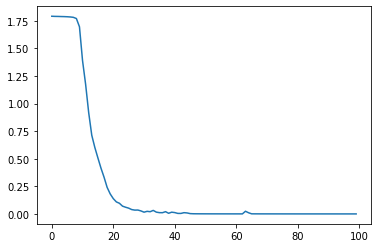

In [553]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Testing

In [558]:
def test(flag):
    if flag == 'train':
        n = n_data_size_train
    elif flag == 'test':
        n = n_data_size_test   
        
    with torch.no_grad():
        right = 0
        for i in range(n):
            category_tensor, inputs = randomTrainingExampleBatch(1,flag,i)
            category = LABELS[int(category_tensor[0])]
            inputs = inputs.to(device)
            inputs = inputs.float()
            output = rnn(inputs)
            guess, guess_i = categoryFromOutput(output)
            category_i = LABELS.index(category)
            if category_i == guess_i:
                right+=1
    print('IMU + CAMERA',flag,'accuracy',right/n)
    return right/n

In [559]:
test('test')

test accuracy 0.9390103567318757


0.9390103567318757

In [560]:
test('train')

train accuracy 0.9484743811168682


0.9484743811168682

C:\Users\zheng\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\zheng\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


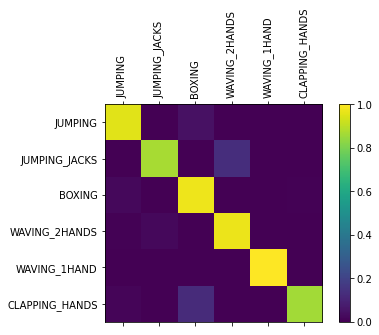

In [561]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = n_data_size_test

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category_tensor, inputs = randomTrainingExampleBatch(1,'test',i)
    category = LABELS[int(category_tensor[0])]
    inputs = inputs.to(device)
    inputs = inputs.float()
    output = rnn(inputs)
    guess, guess_i = categoryFromOutput(output)
    category_i = LABELS.index(category)
    confusion[category_i][guess_i] += 1
     
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + LABELS, rotation=90)
ax.set_yticklabels([''] + LABELS)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### IMU

### Pre-Process 

In [567]:
# Useful Constants
# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 


n_steps = 32 # 32 timesteps per series
n_categories = len(LABELS)

In [568]:
tensor_X_test = torch.from_numpy(X_imu_test)
print('test_imu_data_size:',tensor_X_test.size())
tensor_y_test = torch.from_numpy(y_imu_test)
print('test_imu_label_size:',tensor_y_test.size())
n_data_size_test = tensor_X_test.size()[0]
print('n_data_size_imu_test:',n_data_size_test)

tensor_X_train = torch.from_numpy(X_imu_train)
print('train_imu_data_size:',tensor_X_train.size())
tensor_y_train = torch.from_numpy(y_imu_train)
print('train_imu_label_size:',tensor_y_train.size())
n_data_size_train = tensor_X_train.size()[0]
print('n_data_size_imu_train:',n_data_size_train)

test_imu_data_size: torch.Size([869, 32, 18])
test_imu_label_size: torch.Size([869, 1])
n_data_size_imu_test: 869
train_imu_data_size: torch.Size([3474, 32, 18])
train_imu_label_size: torch.Size([3474, 1])
n_data_size_imu_train: 3474


In [569]:
n_hidden = 128
n_joints = 6*3
n_categories = 6
n_layer = 3
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM(
  (lstm): LSTM(18, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Get Random Data

In [570]:

def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = tensor_X_train
        y = tensor_y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = tensor_X_test
        y = tensor_y_test
        data_size = n_data_size_test
    if num == -1:
        ran_num = random.randint(0,data_size-batch_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num+batch_size,:]
    return category_tensor.long(),pose_sequence_tensor

### Training

In [571]:

import torch.optim as optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

n_iters = 100000
#n_iters = 60000
print_every = 1000
plot_every = 1000
batch_size = 128

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
   
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    
    optimizer.zero_grad()
    # print("intput_type",input_sequence.type)
    input_sequence = input_sequence.float()
    output = rnn(input_sequence)
    # print(output)
    # print(category_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step() 
    #scheduler.step()
    
    #如果tensor只有一个元素,那么可以用.item()的方法取出这个元素作为普通的python数字.
    current_loss += loss.item()
    
    category = LABELS[int(category_tensor[0])]

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f  / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 1% (0m 8s) 1.7790  / BOXING ✗ (WAVING_2HANDS)
2000 2% (0m 16s) 1.7470  / BOXING ✓
3000 3% (0m 24s) 1.5933  / BOXING ✗ (WAVING_2HANDS)
4000 4% (0m 31s) 1.1562  / BOXING ✓
5000 5% (0m 39s) 0.7708  / JUMPING_JACKS ✓
6000 6% (0m 47s) 0.5488  / WAVING_2HANDS ✓
7000 7% (0m 55s) 0.3340  / JUMPING_JACKS ✓
8000 8% (1m 3s) 0.2485  / JUMPING ✓
9000 9% (1m 11s) 0.0998  / CLAPPING_HANDS ✓
10000 10% (1m 20s) 0.0691  / BOXING ✓
11000 11% (1m 28s) 0.0396  / BOXING ✓
12000 12% (1m 36s) 0.0209  / JUMPING ✓
13000 13% (1m 44s) 0.0294  / JUMPING_JACKS ✓
14000 14% (1m 52s) 0.0078  / WAVING_1HAND ✓
15000 15% (2m 1s) 0.0161  / WAVING_1HAND ✓
16000 16% (2m 9s) 0.0054  / BOXING ✓
17000 17% (2m 17s) 0.0040  / WAVING_2HANDS ✓
18000 18% (2m 25s) 0.0042  / WAVING_2HANDS ✓
19000 19% (2m 33s) 0.0033  / WAVING_1HAND ✓
20000 20% (2m 41s) 0.0033  / WAVING_2HANDS ✓
21000 21% (2m 49s) 0.0042  / BOXING ✓
22000 22% (2m 57s) 0.0033  / WAVING_1HAND ✓
23000 23% (3m 5s) 0.0024  / CLAPPING_HANDS ✓
24000 24% (3m 13s) 0.0031 

In [572]:
torch.save(rnn.state_dict(),'C:/Users/zheng/myjupyternotebookscripts/myjupyterscript/Kurs_CACM/final_imu_lstm_6_bn.pth')

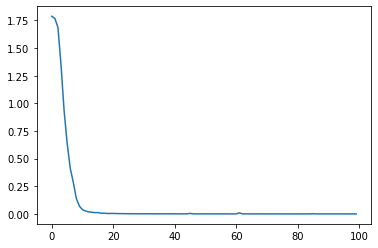

In [573]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Testing

In [574]:
def test(flag):
    if flag == 'train':
        n = n_data_size_train
    elif flag == 'test':
        n = n_data_size_test   
        
    with torch.no_grad():
        right = 0
        for i in range(n):
            category_tensor, inputs = randomTrainingExampleBatch(1,flag,i)
            category = LABELS[int(category_tensor[0])]
            inputs = inputs.to(device)
            inputs = inputs.float()
            output = rnn(inputs)
            guess, guess_i = categoryFromOutput(output)
            category_i = LABELS.index(category)
            if category_i == guess_i:
                right+=1
    print('IMU',flag,'accuracy',right/n)
    return right/n

In [575]:
test('test')

test accuracy 0.7963176064441887


0.7963176064441887

In [576]:
test('train')

train accuracy 0.8033966609096143


0.8033966609096143

C:\Users\zheng\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\zheng\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


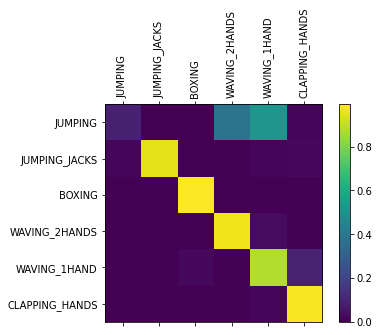

In [577]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = n_data_size_test

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category_tensor, inputs = randomTrainingExampleBatch(1,'test',i)
    category = LABELS[int(category_tensor[0])]
    inputs = inputs.to(device)
    inputs = inputs.float()
    output = rnn(inputs)
    guess, guess_i = categoryFromOutput(output)
    category_i = LABELS.index(category)
    confusion[category_i][guess_i] += 1
     
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + LABELS, rotation=90)
ax.set_yticklabels([''] + LABELS)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Camera

### Pre-Process 

In [578]:
tensor_X_test = torch.from_numpy(X_camera_test)
print('test_camera_data_size:',tensor_X_test.size())
tensor_y_test = torch.from_numpy(y_camera_test)
print('test_camera_label_size:',tensor_y_test.size())
n_data_size_test = tensor_X_test.size()[0]
print('n_data_size_camera_test:',n_data_size_test)

tensor_X_train = torch.from_numpy(X_camera_train)
print('train_camera_data_size:',tensor_X_train.size())
tensor_y_train = torch.from_numpy(y_camera_train)
print('train_camera_label_size:',tensor_y_train.size())
n_data_size_train = tensor_X_train.size()[0]
print('n_data_size_camera_train:',n_data_size_train)

test_camera_data_size: torch.Size([869, 32, 36])
test_camera_label_size: torch.Size([869, 1])
n_data_size_camera_test: 869
train_camera_data_size: torch.Size([3474, 32, 36])
train_camera_label_size: torch.Size([3474, 1])
n_data_size_camera_train: 3474


In [579]:
n_hidden = 128
n_joints = 18*2
n_categories = 6
n_layer = 3
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM(
  (lstm): LSTM(36, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Get Random Data

In [580]:
import random
def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = tensor_X_train
        y = tensor_y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = tensor_X_test
        y = tensor_y_test
        data_size = n_data_size_test
    if num == -1:
        ran_num = random.randint(0,data_size-batch_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num+batch_size,:]
    return category_tensor.long(),pose_sequence_tensor

### Train

In [581]:

import torch.optim as optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

n_iters = 100000
#n_iters = 60000
print_every = 1000
plot_every = 1000
batch_size = 128

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
   
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    
    optimizer.zero_grad()
    # print("intput_type",input_sequence.type)
    input_sequence = input_sequence.float()
    output = rnn(input_sequence)
    # print(output)
    # print(category_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step() 
    #scheduler.step()
    
    #如果tensor只有一个元素,那么可以用.item()的方法取出这个元素作为普通的python数字.
    current_loss += loss.item()
    
    category = LABELS[int(category_tensor[0])]

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f  / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 1% (0m 8s) 1.7918  / BOXING ✗ (WAVING_1HAND)
2000 2% (0m 17s) 1.7896  / BOXING ✗ (CLAPPING_HANDS)
3000 3% (0m 26s) 1.7865  / BOXING ✗ (JUMPING_JACKS)
4000 4% (0m 35s) 1.7858  / BOXING ✗ (JUMPING_JACKS)
5000 5% (0m 44s) 1.7788  / BOXING ✗ (JUMPING)
6000 6% (0m 53s) 1.7811  / BOXING ✓
7000 7% (1m 2s) 1.7677  / BOXING ✗ (CLAPPING_HANDS)
8000 8% (1m 11s) 1.6859  / BOXING ✗ (JUMPING_JACKS)
9000 9% (1m 19s) 1.3902  / CLAPPING_HANDS ✓
10000 10% (1m 28s) 1.2229  / CLAPPING_HANDS ✓
11000 11% (1m 38s) 0.9907  / WAVING_2HANDS ✓
12000 12% (1m 47s) 0.8544  / CLAPPING_HANDS ✓
13000 13% (1m 56s) 0.7085  / BOXING ✓
14000 14% (2m 5s) 0.4858  / JUMPING ✗ (CLAPPING_HANDS)
15000 15% (2m 14s) 0.4336  / BOXING ✗ (JUMPING)
16000 16% (2m 23s) 0.3438  / WAVING_1HAND ✓
17000 17% (2m 32s) 0.3214  / JUMPING ✓
18000 18% (2m 41s) 0.2935  / JUMPING_JACKS ✗ (WAVING_2HANDS)
19000 19% (2m 50s) 0.1236  / JUMPING ✓
20000 20% (2m 59s) 0.1190  / CLAPPING_HANDS ✓
21000 21% (3m 7s) 0.0750  / JUMPING ✓
22000 22% (3m 16s)

In [582]:
torch.save(rnn.state_dict(),'C:/Users/zheng/myjupyternotebookscripts/myjupyterscript/Kurs_CACM/final_camera_lstm_6_bn.pth')

### Testing

In [583]:
def test(flag):
    if flag == 'train':
        n = n_data_size_train
    elif flag == 'test':
        n = n_data_size_test   
        
    with torch.no_grad():
        right = 0
        for i in range(n):
            category_tensor, inputs = randomTrainingExampleBatch(1,flag,i)
            category = LABELS[int(category_tensor[0])]
            inputs = inputs.to(device)
            inputs = inputs.float()
            output = rnn(inputs)
            guess, guess_i = categoryFromOutput(output)
            category_i = LABELS.index(category)
            if category_i == guess_i:
                right+=1
    print('CAMERA',flag,'accuracy',right/n)
    return right/n

In [584]:
test('test')

test accuracy 0.9148446490218642


0.9148446490218642

In [585]:
test('train')

train accuracy 0.9283246977547496


0.9283246977547496

C:\Users\zheng\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\zheng\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


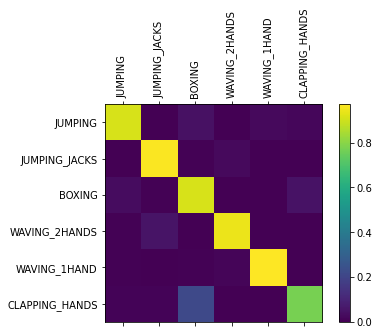

In [586]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = n_data_size_test

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category_tensor, inputs = randomTrainingExampleBatch(1,'test',i)
    category = LABELS[int(category_tensor[0])]
    inputs = inputs.to(device)
    inputs = inputs.float()
    output = rnn(inputs)
    guess, guess_i = categoryFromOutput(output)
    category_i = LABELS.index(category)
    confusion[category_i][guess_i] += 1
     
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + LABELS, rotation=90)
ax.set_yticklabels([''] + LABELS)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()